In [1]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import xml.etree.ElementTree as ET
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams

os.chdir('../')

from res.dispatcher import Dispatcher

rcParams["errorbar.capsize"] = 8.
#rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = '14'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Online folder locations

In [2]:
# Specify locations
offline_folder = 'data/online/instance21/offline_withoutTimeWindows/'
online_folder = 'data/online/instance21/online_withoutTimeWindows/'

## Costs

In [3]:
# Function to get costs' dataframes
def get_costs_dataframes(folder, weights=None):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    columns = ['consumed_energy', 'recharging_cost', 'recharging_time', 'travelled_time', 'total']
    df = pd.DataFrame(columns=columns)
    for folder in folders:
        history_path = folder + '/history.xml'
        root = ET.parse(history_path)
        _fleet: ET.Element = root.find('fleet')
        row_dict = {key: [float(attr)] for key, attr in _fleet.attrib.items()}
        costs = (row_dict['travelled_time'][0], row_dict['consumed_energy'][0]/24., row_dict['recharging_time'][0], row_dict['recharging_cost'][0])
        if weights is None:
            total_cost = sum(costs)
        else:
            total_cost = np.dot(np.asarray(costs), np.asarray(weights))  
        row_dict['total'] = total_cost
        row = pd.DataFrame(row_dict)
        df = df.append(row, ignore_index=True)
    
    return df.dropna()


weights = (0.1 / 2.218, 1. / 0.4364, 1. / 100, 1. / 500)

In [13]:
# Get offline costs
off_df = get_costs_dataframes(offline_folder, weights)

off_statistics = off_df.describe()
off_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,28.000000,2.800000e+01,28.000000,28.000000,28.000000
mean,56.772390,1.402551e+05,79.174040,288.979976,299.751395
std,1.463840,2.963789e-11,1.725162,9.882645,0.474271
min,53.778404,1.402551e+05,75.108266,272.044166,299.002624
25%,55.684275,1.402551e+05,78.188040,281.713743,299.385204
50%,56.765961,1.402551e+05,79.433512,288.790683,299.703535
75%,57.905462,1.402551e+05,80.298409,295.472365,300.122545
max,59.736728,1.402551e+05,81.861833,312.668933,300.966427


In [14]:
# Get online costs
on_df = get_costs_dataframes(online_folder, weights)

on_statistics = on_df.describe()
on_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,36.957951,61482.538400,32.549579,209.958798,136.285381
std,10.049752,33282.423793,17.620107,53.623509,69.239603
min,11.272660,20923.850959,11.077333,67.951956,46.098427
25%,35.202998,37291.986921,19.742817,208.346177,87.662631
50%,38.795355,63870.011485,33.813535,217.420136,141.621658
75%,41.903754,72048.497201,38.143322,238.870982,158.864712
max,47.503727,120706.929216,63.903668,259.871656,258.304949


[Text(0, 0, 'Off-E-VRP only'), Text(0, 0, 'Off-E-VRP + On-E-VRP')]

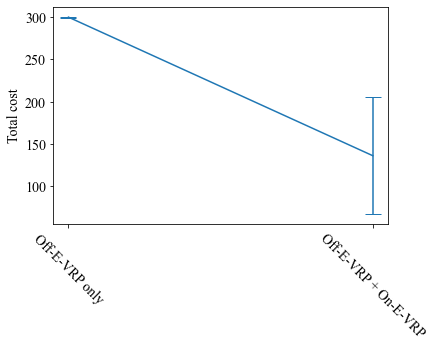

In [15]:
def get_mean_std(df, column_name):
    mean = df[column_name]['mean']
    std = df[column_name]['std']
    return mean, std

mean_off, std_off = get_mean_std(off_statistics, 'total')
mean_on, std_on = get_mean_std(on_statistics, 'total')


fig = plt.figure()
plt.errorbar([0, 1], [mean_off, mean_on], yerr=[std_off, std_on])

plt.ylabel('Total cost')

ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

In [16]:
print(mean_off, mean_on)

299.75139464448733 136.28538108183804


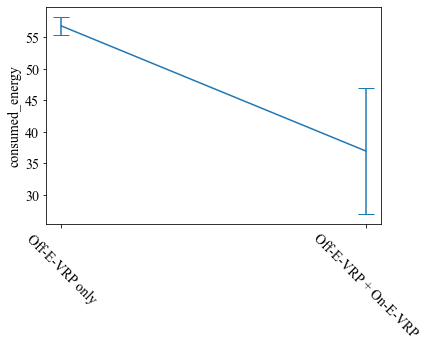

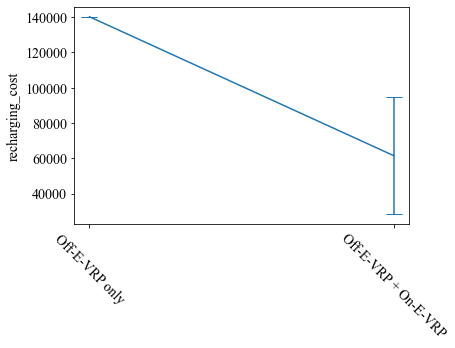

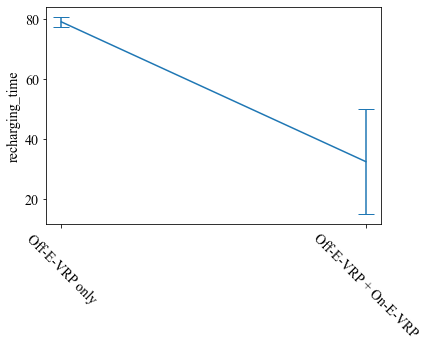

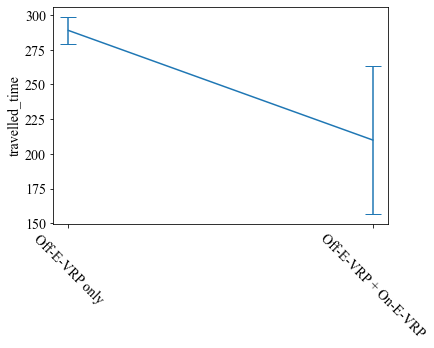

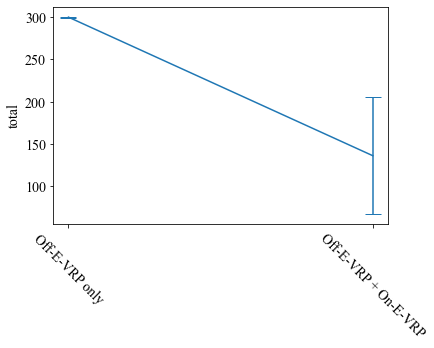

In [17]:
for column in off_statistics.columns:
    mean_off, std_off = get_mean_std(off_statistics, column)
    mean_on, std_on = get_mean_std(on_statistics, column)
    
    fig = plt.figure()
    
    plt.errorbar([0, 1], [mean_off, mean_on], yerr=[std_off, std_on])
    
    plt.ylabel(column)

    ax = plt.gca()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

## Constraints violations

In [10]:
# Function to get costs' dataframes
def get_constraints_dataframes(folder):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    columns = ['time_window_down', 'time_window_upp', 'alpha_up', 'alpha_down', 'max_tour_time', 'total']
    df = pd.DataFrame(columns=columns)
    for folder in folders:
        history_path = folder + '/history.xml'
        root = ET.parse(history_path)
        for _vehicle in root.iter('vehicle'):
            _violated_constraints = _vehicle.find('violated_constraints')
            for _violated_constraint in _violated_constraints:
                row = {key: 0 for key in columns}
                row[_violated_constraint.attrib['type']] = 1
                row['total'] = 1
                df = df.append(row, ignore_index=True)
    return df.dropna().sum()

In [11]:
get_constraints_dataframes(offline_folder)

time_window_down     0.0
time_window_upp      0.0
alpha_up             0.0
alpha_down          68.0
max_tour_time        0.0
total               68.0
dtype: float64

In [12]:
get_constraints_dataframes(online_folder)

time_window_down    0.0
time_window_upp     0.0
alpha_up            0.0
alpha_down          0.0
max_tour_time       0.0
total               0.0
dtype: float64